In [17]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter, defaultdict
import random
import json

In [ ]:
# Konfiguration
BASE_PATH = Path("/pscratch/sd/t/tbuerger/data/optPhotonSensitiveSurface/rawHomogeneousNCsSSD300PMTs")
NUM_FILES = 1000
RUNS = [f"run_{i:03d}" for i in range(1, 11)]

def find_all_files(base_path, runs):
    """Findet alle output_*.hdf5 Files in allen Runs"""
    all_files = []
    for run in runs:
        run_path = base_path / run
        if run_path.exists():
            files = sorted(run_path.glob("output_*.hdf5"))
            all_files.extend(files)
    return all_files

def analyze_file(file_path):
    """Analysiert ein einzelnes File"""
    try:
        with h5py.File(file_path, 'r') as f:
            # Lade ALLE Neutron Captures
            nc_evtid = f['hit']['MyNeutronCaptureOutput']['evtid']['pages'][:]
            nc_track_id = f['hit']['MyNeutronCaptureOutput']['nC_track_id']['pages'][:]
            
            all_nc_tuples = set(zip(nc_evtid, nc_track_id))
            total_nc_events = len(all_nc_tuples)
            
            # Lade optische Photonen
            optical_evtid = f['hit']['optical']['evtid']['pages'][:]
            optical_nc_track_id = f['hit']['optical']['nC_track_id']['pages'][:]
            optical_det_uid = f['hit']['optical']['det_uid']['pages'][:]
            
            total_photons = len(optical_evtid)
            
            # Filter: Tyvek-Detektoren UND nC_track_id >= 0
            valid_detector_mask = np.isin(optical_det_uid, [1965, 1966, 1967, 1968]) 
            orphaned_mask = optical_nc_track_id < 0
            
            # Kombiniere beide Bedingungen
            valid_mask = valid_detector_mask & ~orphaned_mask
            orphaned_count = np.sum(~valid_detector_mask | orphaned_mask)
            
            # Valid photons (nC_track_id >= 0)
            valid_mask = ~orphaned_mask
            valid_evtid = optical_evtid[valid_mask]
            valid_nc_track_id = optical_nc_track_id[valid_mask]
            
            # ===== 3. Zähle Photonen pro NC =====
            # Counter: (evtid, nC_track_id) -> Anzahl Photonen
            nc_photon_counter = Counter(zip(valid_evtid, valid_nc_track_id))
            
            # Set der NCs die Photonen haben
            nc_with_photons = set(nc_photon_counter.keys())
            
            # ===== 4. NCs mit 0 Photonen =====
            nc_with_zero_photons = all_nc_tuples - nc_with_photons
            
            # Erstelle finale Photon-Counts (inkl. 0)
            photon_counts_per_nc = []
            
            # NCs mit 0 Photonen
            photon_counts_per_nc.extend([0] * len(nc_with_zero_photons))
            
            # NCs mit >0 Photonen
            photon_counts_per_nc.extend(nc_photon_counter.values())
            
            return {
                'file': file_path.name,
                'run': file_path.parent.name,
                'total_photons': total_photons,
                'orphaned_photons': orphaned_count,
                'valid_photons': total_photons - orphaned_count,
                'total_nc_events': total_nc_events,
                'nc_with_photons': len(nc_with_photons),
                'nc_with_zero_photons': len(nc_with_zero_photons),
                'photon_counts_per_nc': photon_counts_per_nc,
                'success': True
            }
    except Exception as e:
        print(f"❌ Fehler bei {file_path.name}: {e}")
        import traceback
        traceback.print_exc()
        return {
            'file': file_path.name,
            'run': file_path.parent.name,
            'success': False
        }

ANALYSE: Optische Photonen → Neutron Capture Zuordnung

1. Suche Files in /pscratch/sd/t/tbuerger/data/optPhotonSensitiveSurface/rawHomogeneousNCsSSD300PMTs...
   Gefunden: 2560 Files in 10 Runs
   → Analysiere 1000 zufällig ausgewählte Files

2. Analysiere Files...
   Progress: 10/1000
   Progress: 20/1000
   Progress: 30/1000
   Progress: 40/1000
   Progress: 50/1000
   Progress: 60/1000
   Progress: 70/1000
   Progress: 80/1000
   Progress: 90/1000
   Progress: 100/1000
   Progress: 110/1000
   Progress: 120/1000
   Progress: 130/1000
   Progress: 140/1000
   Progress: 150/1000
   Progress: 160/1000
   Progress: 170/1000
   Progress: 180/1000
   Progress: 190/1000
   Progress: 200/1000
   Progress: 210/1000
   Progress: 220/1000
   Progress: 230/1000
   Progress: 240/1000
   Progress: 250/1000
   Progress: 260/1000
   Progress: 270/1000
   Progress: 280/1000
   Progress: 290/1000
   Progress: 300/1000
   Progress: 310/1000
   Progress: 320/1000
   Progress: 330/1000
   Progress: 340

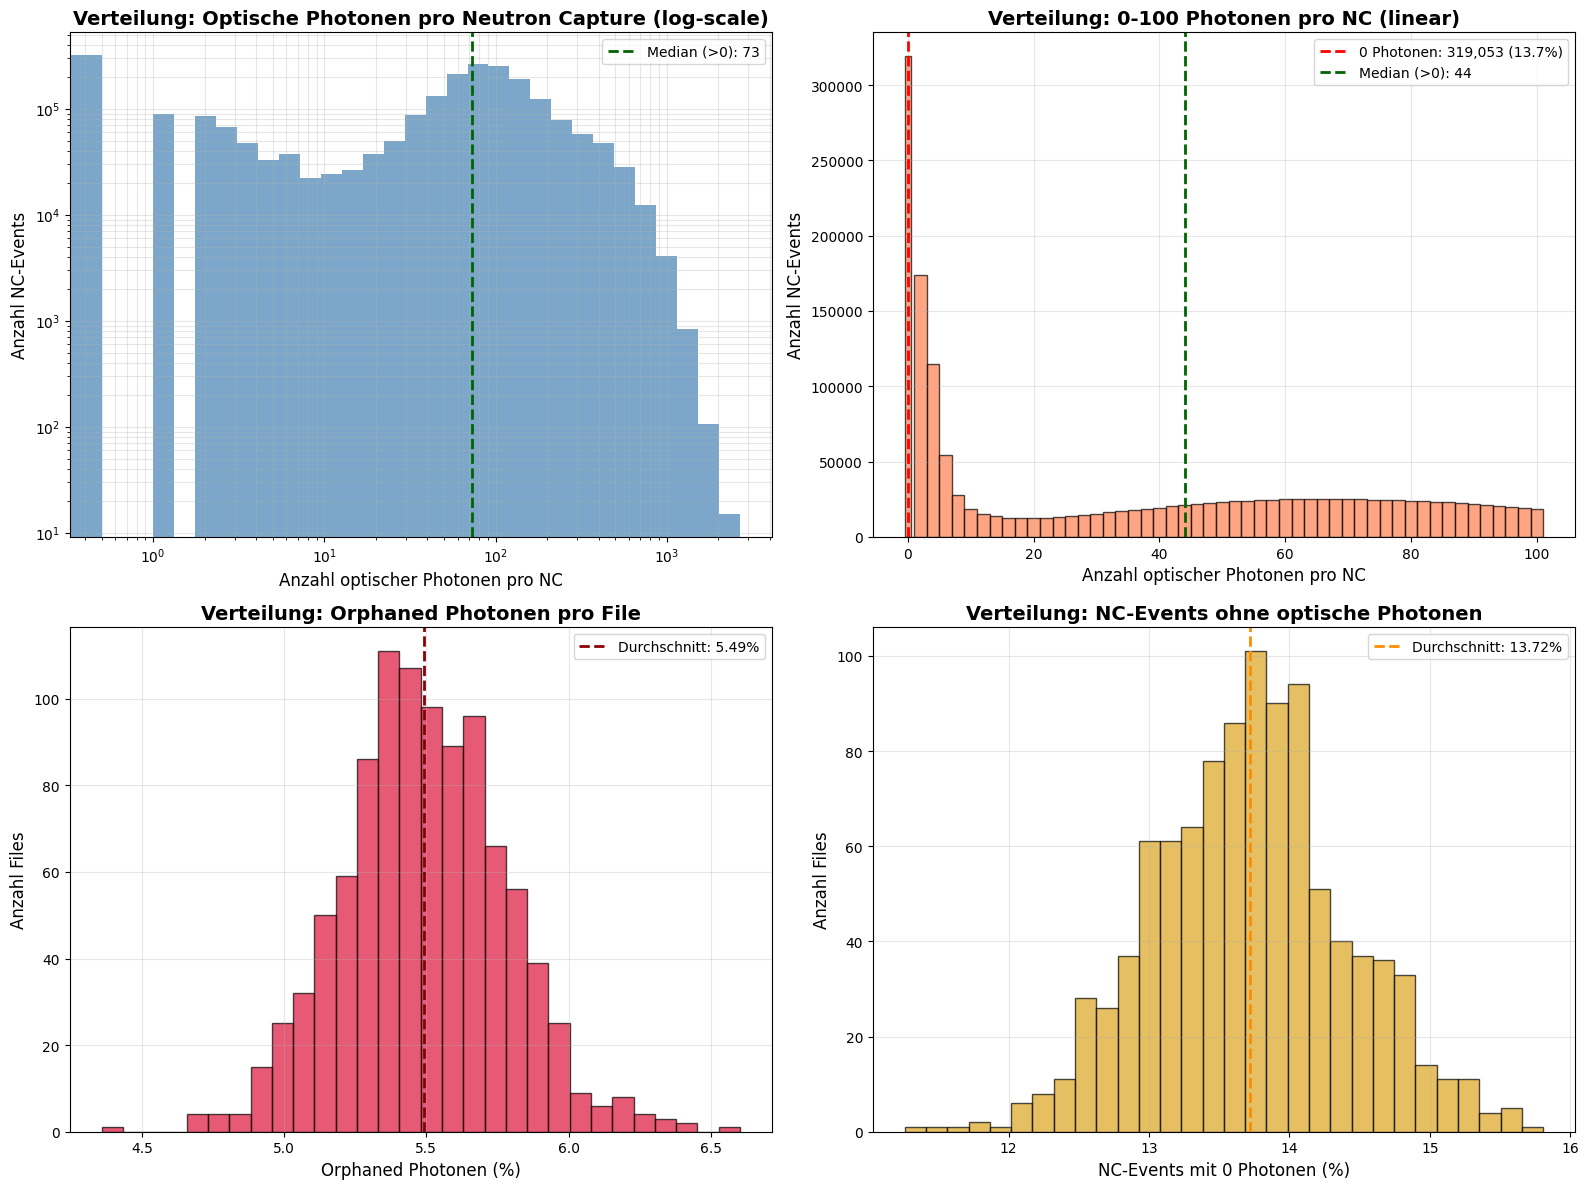

In [19]:
print("="*60)
print("ANALYSE: Optische Photonen → Neutron Capture Zuordnung")
print("="*60)

# Finde alle Files
print(f"\n1. Suche Files in {BASE_PATH}...")
all_files = find_all_files(BASE_PATH, RUNS)
print(f"   Gefunden: {len(all_files)} Files in {len(RUNS)} Runs")

# Zufällige Auswahl
if len(all_files) < NUM_FILES:
    print(f"   ⚠ Nur {len(all_files)} Files verfügbar, analysiere alle")
    selected_files = all_files
else:
    random.seed(42)  # Reproduzierbar
    selected_files = random.sample(all_files, NUM_FILES)

print(f"   → Analysiere {len(selected_files)} zufällig ausgewählte Files\n")

# Analysiere Files
print("2. Analysiere Files...")
results = []
for i, file_path in enumerate(selected_files, 1):
    if i % 10 == 0:
        print(f"   Progress: {i}/{len(selected_files)}")
    result = analyze_file(file_path)
    if result['success']:
        results.append(result)

print(f"   ✓ {len(results)} Files erfolgreich analysiert\n")

# Aggregate Statistiken
print("3. Berechne Statistiken...")
total_photons = sum(r['total_photons'] for r in results)
total_orphaned = sum(r['orphaned_photons'] for r in results)
total_valid = sum(r['valid_photons'] for r in results)

total_nc_events = sum(r['total_nc_events'] for r in results)
total_nc_with_photons = sum(r['nc_with_photons'] for r in results)
total_nc_with_zero = sum(r['nc_with_zero_photons'] for r in results)

# Kombiniere alle Photon-Counts (inkl. 0)
all_photon_counts = []
for r in results:
    all_photon_counts.extend(r['photon_counts_per_nc'])

all_photon_counts = np.array(all_photon_counts)

# Statistiken
orphaned_percent = (total_orphaned / total_photons * 100) if total_photons > 0 else 0
nc_with_zero_percent = (total_nc_with_zero / total_nc_events * 100) if total_nc_events > 0 else 0

print(f"\n{'='*60}")
print(f"GESAMT-STATISTIK")
print(f"{'='*60}")
print(f"Analysierte Files:        {len(results)}")
print(f"\nOptische Photonen:")
print(f"  Total:                  {total_photons:,}")
print(f"  Mit NC-ID (valid):      {total_valid:,} ({100-orphaned_percent:.2f}%)")
print(f"  Orphaned (nC_id<0):     {total_orphaned:,} ({orphaned_percent:.2f}%)")
print(f"\nNeutron Captures:")
print(f"  Total NC-Events:        {total_nc_events:,}")
print(f"  Mit Photonen (>0):      {total_nc_with_photons:,} ({100-nc_with_zero_percent:.2f}%)")
print(f"  Ohne Photonen (=0):     {total_nc_with_zero:,} ({nc_with_zero_percent:.2f}%)")
print(f"\nPhotonen pro NC-Event:")
print(f"  Durchschnitt:           {np.mean(all_photon_counts):.2f}")
print(f"  Median:                 {np.median(all_photon_counts):.0f}")
print(f"  Std Dev:                {np.std(all_photon_counts):.2f}")
print(f"  Min:                    {np.min(all_photon_counts):.0f}")
print(f"  Max:                    {np.max(all_photon_counts):,}")

print(f"\n{'='*60}")
print(f"PRO FILE BREAKDOWN (Top 10 höchste Orphaned %)")
print(f"{'='*60}")

# Sortiere nach Orphaned %
results_sorted = sorted(results, 
                        key=lambda r: r['orphaned_photons']/r['total_photons'] if r['total_photons']>0 else 0, 
                        reverse=True)

for r in results_sorted[:10]:
    orphaned_pct = (r['orphaned_photons'] / r['total_photons'] * 100) if r['total_photons'] > 0 else 0
    nc_zero_pct = (r['nc_with_zero_photons'] / r['total_nc_events'] * 100) if r['total_nc_events'] > 0 else 0
    print(f"  {r['run']}/{r['file']}: "
            f"Orphaned: {orphaned_pct:.1f}%, "
            f"NC mit 0 Photonen: {nc_zero_pct:.1f}%")

# Visualisierung
print(f"\n4. Erstelle Plots...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ===== Plot 1a: Histogramm Photonen pro NC (logarithmisch) =====
ax1 = axes[0, 0]

# Separate 0 und >0
zero_count = np.sum(all_photon_counts == 0)
nonzero_counts = all_photon_counts[all_photon_counts > 0]

if len(nonzero_counts) > 0:
    max_photons = np.max(nonzero_counts)
    
    # Bins: 0 separat, dann logarithmisch
    bins = [0, 0.5] + list(np.logspace(0, np.log10(max_photons), 29))
    
    counts, bin_edges = np.histogram(all_photon_counts, bins=bins)
    
    # Plot
    ax1.stairs(counts, bin_edges, fill=True, alpha=0.7, color='steelblue', edgecolor='black')
    ax1.set_xlabel('Anzahl optischer Photonen pro NC', fontsize=12)
    ax1.set_ylabel('Anzahl NC-Events', fontsize=12)
    ax1.set_title('Verteilung: Optische Photonen pro Neutron Capture (log-scale)', 
                    fontsize=14, fontweight='bold')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3, which='both')
    
    # Annotate 0-bin
    ax1.annotate(f'0 Photonen:\n{zero_count:,} NC-Events\n({nc_with_zero_percent:.1f}%)', 
                xy=(0.1, counts[0]), xytext=(0.5, counts[0]*2),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=10, color='red', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))
    
    ax1.axvline(np.median(nonzero_counts), color='darkgreen', linestyle='--', 
                label=f'Median (>0): {np.median(nonzero_counts):.0f}', linewidth=2)
    ax1.legend(fontsize=10)

# ===== Plot 1b: Linear Histogram für 0-100 Photonen =====
ax2 = axes[0, 1]

photon_counts_small = all_photon_counts[all_photon_counts <= 100]

if len(photon_counts_small) > 0:
    # Separate bin for 0
    bins_small = [-0.5, 0.5] + list(range(1, 102, 2))
    
    ax2.hist(photon_counts_small, bins=bins_small, alpha=0.7, color='coral', edgecolor='black')
    ax2.set_xlabel('Anzahl optischer Photonen pro NC', fontsize=12)
    ax2.set_ylabel('Anzahl NC-Events', fontsize=12)
    ax2.set_title('Verteilung: 0-100 Photonen pro NC (linear)', 
                    fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Highlight 0-bin
    ax2.axvline(0, color='red', linestyle='--', linewidth=2,
                label=f'0 Photonen: {zero_count:,} ({nc_with_zero_percent:.1f}%)')
    
    if len(nonzero_counts) > 0:
        median_small = np.median(photon_counts_small[photon_counts_small > 0])
        ax2.axvline(median_small, color='darkgreen', linestyle='--',
                    label=f'Median (>0): {median_small:.0f}', linewidth=2)
    
    ax2.legend(fontsize=10)

# ===== Plot 2: Orphaned % pro File =====
ax3 = axes[1, 0]

orphaned_pcts = [(r['orphaned_photons'] / r['total_photons'] * 100) if r['total_photons'] > 0 else 0 
                    for r in results]

ax3.hist(orphaned_pcts, bins=30, alpha=0.7, color='crimson', edgecolor='black')
ax3.axvline(orphaned_percent, color='darkred', linestyle='--', linewidth=2,
            label=f'Durchschnitt: {orphaned_percent:.2f}%')
ax3.set_xlabel('Orphaned Photonen (%)', fontsize=12)
ax3.set_ylabel('Anzahl Files', fontsize=12)
ax3.set_title('Verteilung: Orphaned Photonen pro File', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# ===== Plot 3: NC mit 0 Photonen % pro File =====
ax4 = axes[1, 1]

nc_zero_pcts = [(r['nc_with_zero_photons'] / r['total_nc_events'] * 100) if r['total_nc_events'] > 0 else 0 
                for r in results]

ax4.hist(nc_zero_pcts, bins=30, alpha=0.7, color='goldenrod', edgecolor='black')
ax4.axvline(nc_with_zero_percent, color='darkorange', linestyle='--', linewidth=2,
            label=f'Durchschnitt: {nc_with_zero_percent:.2f}%')
ax4.set_xlabel('NC-Events mit 0 Photonen (%)', fontsize=12)
ax4.set_ylabel('Anzahl Files', fontsize=12)
ax4.set_title('Verteilung: NC-Events ohne optische Photonen', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()

# Speichern
output_path = Path.cwd() / "optical_photon_nc_analysis.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"   ✓ Plot gespeichert: {output_path}")

# ===== Zusätzliche Statistik-Datei =====
stats_file = Path.cwd() / "optical_photon_statistics.txt"
with open(stats_file, 'w') as f:
    f.write("="*60 + "\n")
    f.write("OPTICAL PHOTON → NEUTRON CAPTURE ANALYSIS\n")
    f.write("="*60 + "\n\n")
    f.write(f"Analysierte Files: {len(results)}\n\n")
    
    f.write("OPTISCHE PHOTONEN:\n")
    f.write(f"  Total: {total_photons:,}\n")
    f.write(f"  Valid (mit NC-ID): {total_valid:,} ({100-orphaned_percent:.2f}%)\n")
    f.write(f"  Orphaned (nC_track_id<0): {total_orphaned:,} ({orphaned_percent:.2f}%)\n\n")
    
    f.write("NEUTRON CAPTURES:\n")
    f.write(f"  Total NC-Events: {total_nc_events:,}\n")
    f.write(f"  Mit Photonen (>0): {total_nc_with_photons:,} ({100-nc_with_zero_percent:.2f}%)\n")
    f.write(f"  Ohne Photonen (=0): {total_nc_with_zero:,} ({nc_with_zero_percent:.2f}%)\n\n")
    
    f.write("PHOTONEN PRO NC-EVENT:\n")
    f.write(f"  Durchschnitt: {np.mean(all_photon_counts):.2f}\n")
    f.write(f"  Median: {np.median(all_photon_counts):.0f}\n")
    f.write(f"  Std Dev: {np.std(all_photon_counts):.2f}\n")
    f.write(f"  Min: {np.min(all_photon_counts):.0f}\n")
    f.write(f"  Max: {np.max(all_photon_counts):,}\n")
    f.write(f"  Quartile 25%: {np.percentile(all_photon_counts, 25):.0f}\n")
    f.write(f"  Quartile 75%: {np.percentile(all_photon_counts, 75):.0f}\n\n")
    
    f.write("PER-FILE DETAILS:\n")
    f.write("-"*60 + "\n")
    for r in results_sorted:
        orphaned_pct = (r['orphaned_photons'] / r['total_photons'] * 100) if r['total_photons'] > 0 else 0
        nc_zero_pct = (r['nc_with_zero_photons'] / r['total_nc_events'] * 100) if r['total_nc_events'] > 0 else 0
        f.write(f"{r['run']}/{r['file']}:\n")
        f.write(f"  Photonen: {r['total_photons']:,} total, {r['orphaned_photons']:,} orphaned ({orphaned_pct:.2f}%)\n")
        f.write(f"  NC-Events: {r['total_nc_events']:,} total, {r['nc_with_zero_photons']:,} mit 0 Photonen ({nc_zero_pct:.2f}%)\n\n")

print(f"   ✓ Statistiken gespeichert: {stats_file}")

print(f"\n{'='*60}")
print(f"ANALYSE ABGESCHLOSSEN!")
print(f"{'='*60}\n")

plt.show()


5. Erstelle erweiterte NC-Analysen...
   ✓ Material-Mapping geladen: 14 Materialien
   Lade zusätzliche NC-Daten...
   Progress: 20/1000
   Progress: 40/1000
   Progress: 60/1000
   Progress: 80/1000
   Progress: 100/1000
   Progress: 120/1000
   Progress: 140/1000
   Progress: 160/1000
   Progress: 180/1000
   Progress: 200/1000
   Progress: 220/1000
   Progress: 240/1000
   Progress: 260/1000
   Progress: 280/1000
   Progress: 300/1000
   Progress: 320/1000
   Progress: 340/1000
   Progress: 360/1000
   Progress: 380/1000
   Progress: 400/1000
   Progress: 420/1000
   Progress: 440/1000
   Progress: 460/1000
   Progress: 480/1000
   Progress: 500/1000
   Progress: 520/1000
   Progress: 540/1000
   Progress: 560/1000
   Progress: 580/1000
   Progress: 600/1000
   Progress: 620/1000
   Progress: 640/1000
   Progress: 660/1000
   Progress: 680/1000
   Progress: 700/1000
   Progress: 720/1000
   Progress: 740/1000
   Progress: 760/1000
   Progress: 780/1000
   Progress: 800/1000
   Prog

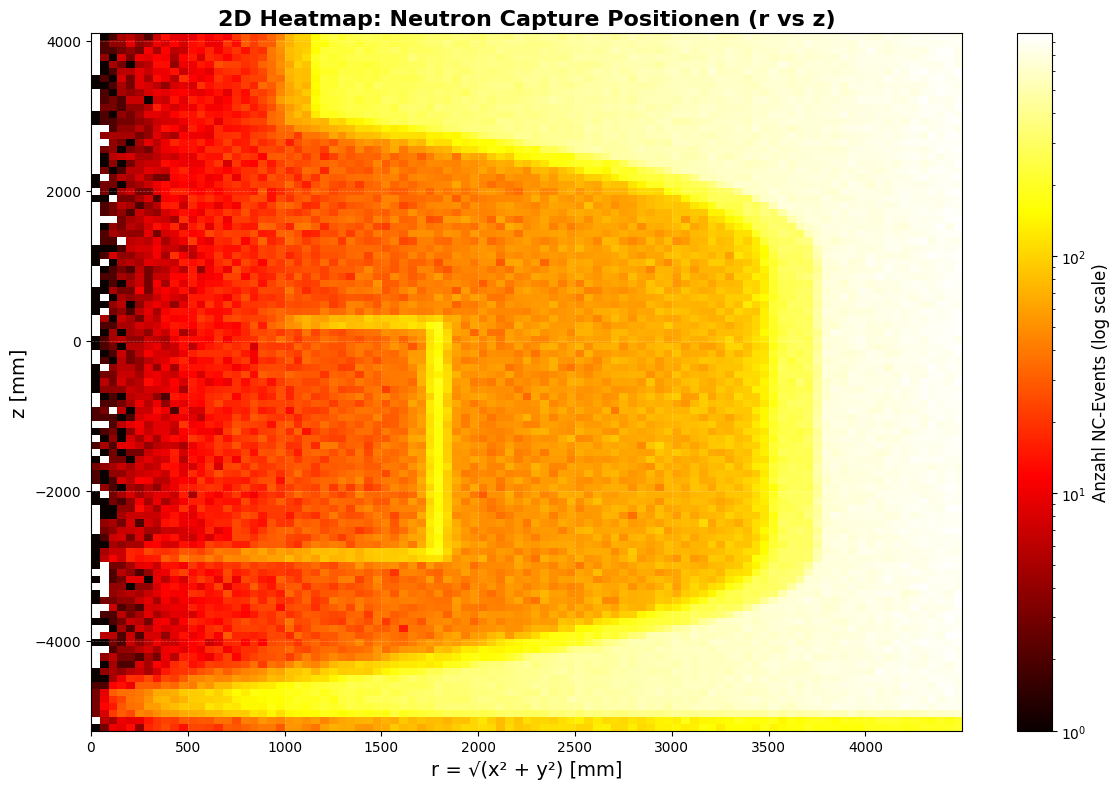

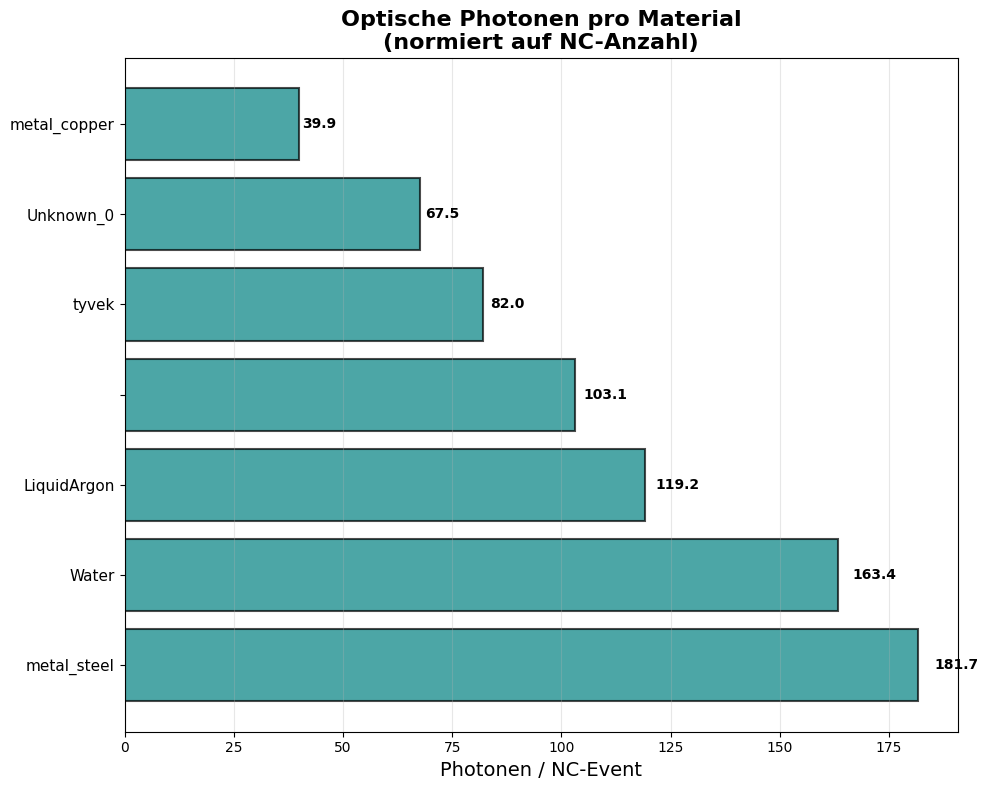

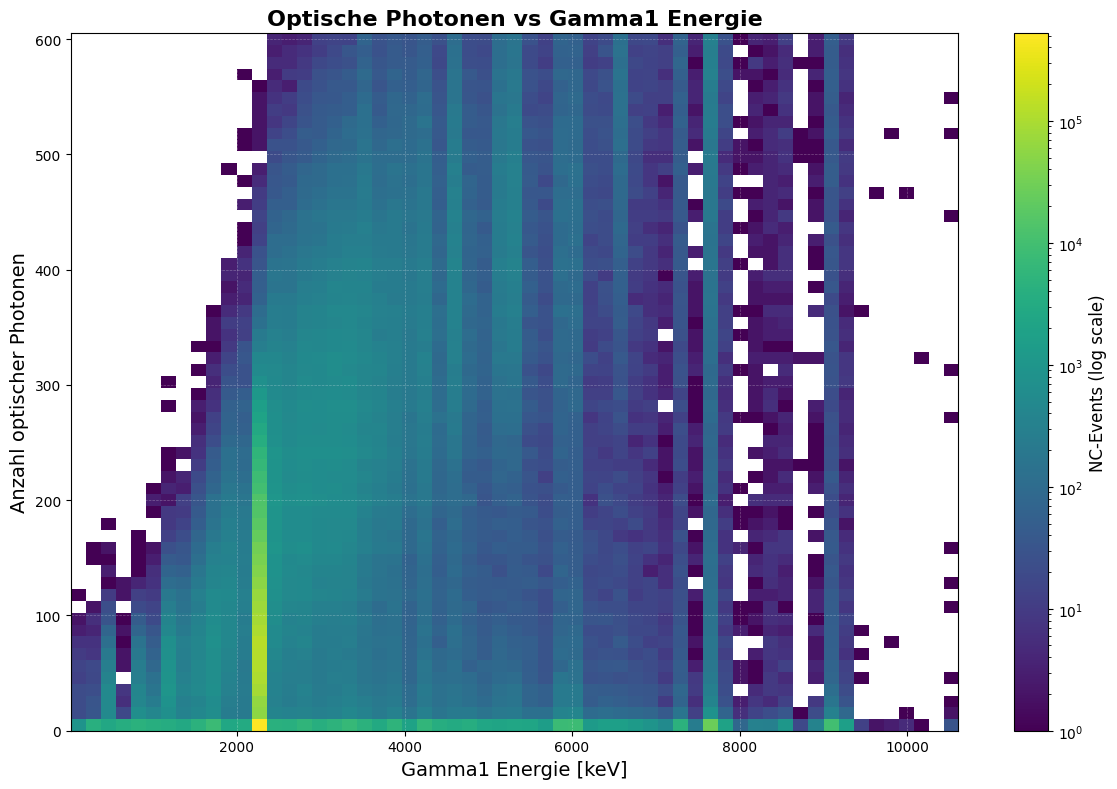

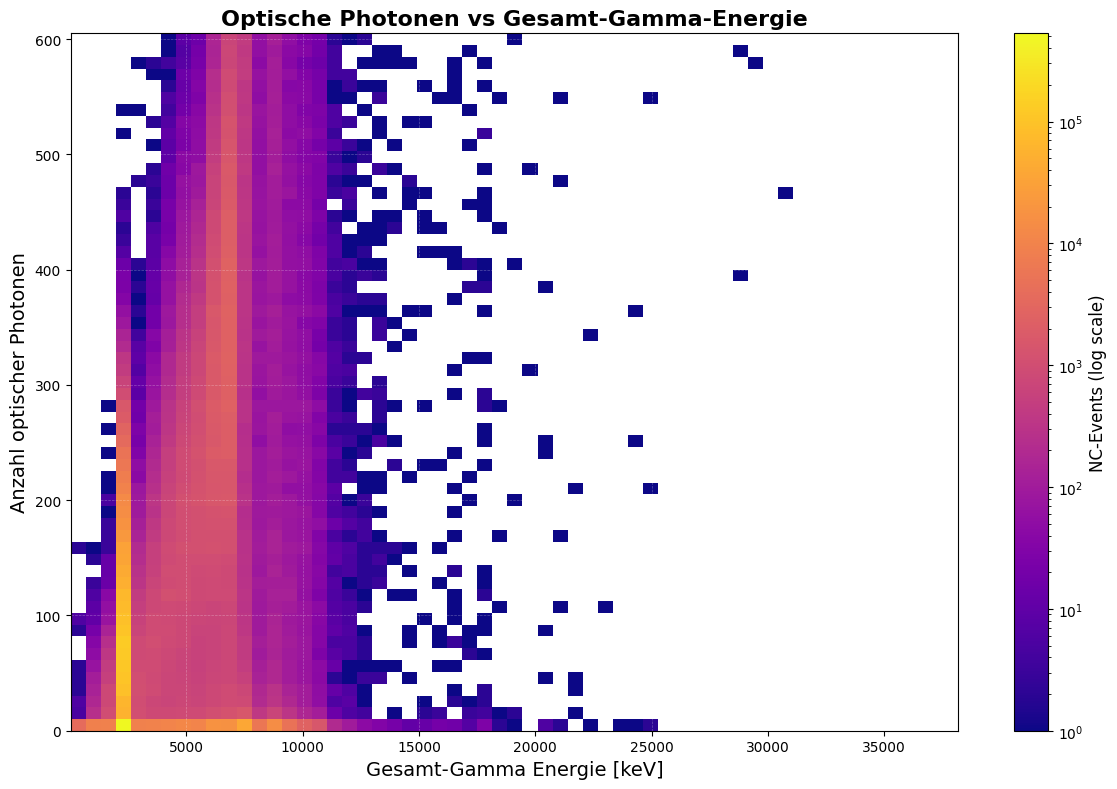

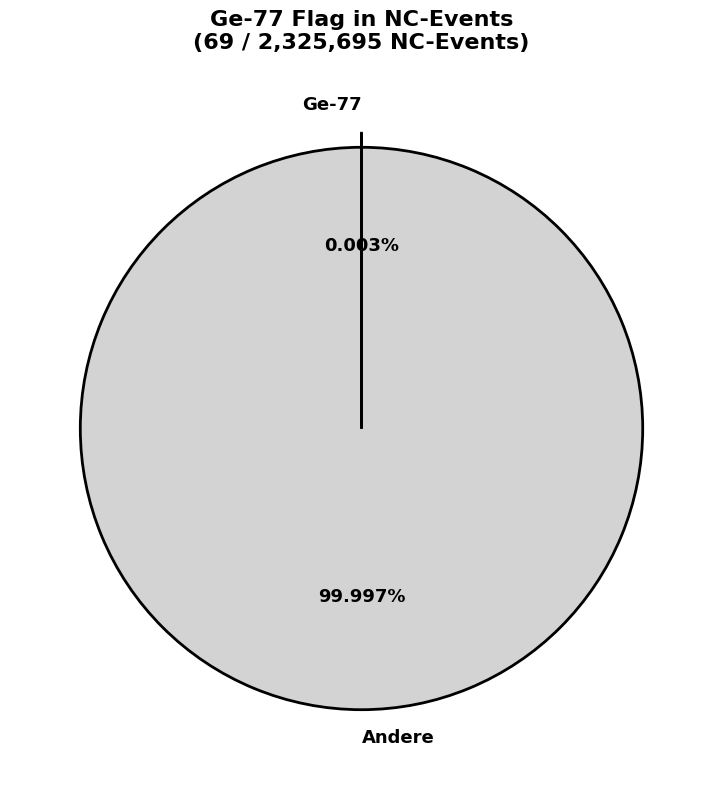

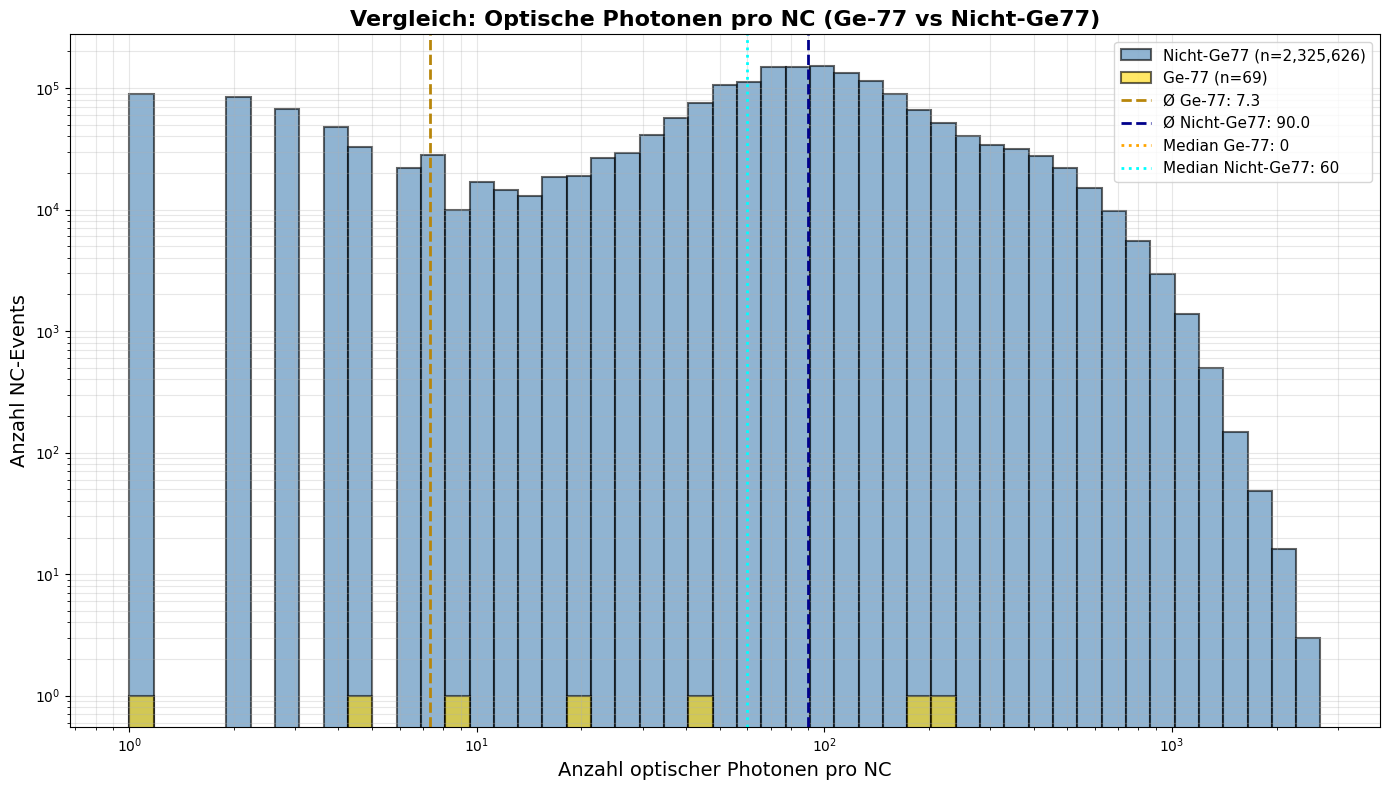

In [ ]:
# =========================================================================
# TEIL 5: ERWEITERTE NEUTRON CAPTURE ANALYSEN
# =========================================================================

print(f"\n5. Erstelle erweiterte NC-Analysen...")

# Material-Mapping laden
material_mapping_path = Path("/global/cfs/projectdirs/legend/users/tbuerger/postprocessing/src/mappings/globalMaterialMappings.json")
material_id_to_name = {}
try:
    with open(material_mapping_path, 'r') as f:
        material_name_to_id = json.load(f)
        # Invertiere Mapping: ID -> Name
        material_id_to_name = {v: k for k, v in material_name_to_id.items()}
    print(f"   ✓ Material-Mapping geladen: {len(material_id_to_name)} Materialien")
except Exception as e:
    print(f"   ⚠ Konnte Material-Mapping nicht laden: {e}")
    print(f"   Verwende Material-IDs statt Namen")

# Sammle zusätzliche NC-Daten
all_nc_x = []
all_nc_y = []
all_nc_z = []
all_nc_material_ids = []
all_nc_gamma1_energies = []
all_nc_gamma_total_energies = []
all_nc_ge77_flags = []
all_nc_photon_counts_detailed = []  # Für Ge77-Analyse

print("   Lade zusätzliche NC-Daten...")
for i, file_path in enumerate(selected_files, 1):
    if i % 20 == 0:
        print(f"   Progress: {i}/{len(selected_files)}")
    
    try:
        with h5py.File(file_path, 'r') as f:
            # NC-Positionen
            nc_x = f['hit']['MyNeutronCaptureOutput']['nC_x_position_in_m']['pages'][:] * 1000  # m → mm
            nc_y = f['hit']['MyNeutronCaptureOutput']['nC_y_position_in_m']['pages'][:] * 1000
            nc_z = f['hit']['MyNeutronCaptureOutput']['nC_z_position_in_m']['pages'][:] * 1000
            
            # NC-Properties
            nc_material_ids = f['hit']['MyNeutronCaptureOutput']['nC_material_id']['pages'][:]
            nc_gamma1_E = f['hit']['MyNeutronCaptureOutput']['gamma1_E']['pages'][:]
            nc_gamma_total_E = f['hit']['MyNeutronCaptureOutput']['nC_gamma_total_energy_in_keV']['pages'][:]
            nc_ge77_flags = f['hit']['MyNeutronCaptureOutput']['nC_flag_Ge77']['pages'][:]
            
            # NC-IDs für Ge77-Photon-Zuordnung
            nc_evtid = f['hit']['MyNeutronCaptureOutput']['evtid']['pages'][:]
            nc_track_id = f['hit']['MyNeutronCaptureOutput']['nC_track_id']['pages'][:]
            
            # Optische Photonen für Ge77-Analyse
            optical_evtid = f['hit']['optical']['evtid']['pages'][:]
            optical_nc_track_id = f['hit']['optical']['nC_track_id']['pages'][:]
            optical_det_uid = f['hit']['optical']['det_uid']['pages'][:]  # ← NEU
            optical_valid_mask = (optical_nc_track_id >= 0) & np.isin(optical_det_uid, [1965, 1966, 1967, 1968])
            
            # Zähle Photonen pro NC
            optical_counter = Counter(zip(optical_evtid[optical_valid_mask], 
                                            optical_nc_track_id[optical_valid_mask]))
            
            # Für jedes NC: Photon-Count und Ge77-Flag
            for j in range(len(nc_evtid)):
                nc_tuple = (nc_evtid[j], nc_track_id[j])
                photon_count = optical_counter.get(nc_tuple, 0)
                
                all_nc_x.append(nc_x[j])
                all_nc_y.append(nc_y[j])
                all_nc_z.append(nc_z[j])
                all_nc_material_ids.append(nc_material_ids[j])
                all_nc_gamma1_energies.append(nc_gamma1_E[j])
                all_nc_gamma_total_energies.append(nc_gamma_total_E[j])
                all_nc_ge77_flags.append(nc_ge77_flags[j])
                all_nc_photon_counts_detailed.append(photon_count)
    
    except Exception as e:
        print(f"   ⚠ Fehler bei {file_path.name}: {e}")
        continue

# Arrays konvertieren
all_nc_x = np.array(all_nc_x)
all_nc_y = np.array(all_nc_y)
all_nc_z = np.array(all_nc_z)
all_nc_r = np.sqrt(all_nc_x**2 + all_nc_y**2)
all_nc_material_ids = np.array(all_nc_material_ids)
all_nc_gamma1_energies = np.array(all_nc_gamma1_energies)
all_nc_gamma_total_energies = np.array(all_nc_gamma_total_energies)
all_nc_ge77_flags = np.array(all_nc_ge77_flags, dtype=bool)
all_nc_photon_counts_detailed = np.array(all_nc_photon_counts_detailed)

total_nc_analyzed = len(all_nc_x)

print(f"   ✓ {total_nc_analyzed:,} NC-Events analysiert\n")

# =========================================================================
# PLOT 1: 2D Heatmap (r vs z)
# =========================================================================

print("   Erstelle Plot 1: 2D Heatmap (r vs z)...")

fig1, ax1 = plt.subplots(figsize=(12, 8))

# Binning
r_bins = np.linspace(0, np.max(all_nc_r), 100)
z_bins = np.linspace(np.min(all_nc_z), np.max(all_nc_z), 100)

hist_2d, r_edges, z_edges = np.histogram2d(all_nc_r, all_nc_z, bins=[r_bins, z_bins])

# Plot mit logarithmischer Farbskala
im1 = ax1.imshow(hist_2d.T, origin='lower', aspect='auto',
                    extent=[r_edges[0], r_edges[-1], z_edges[0], z_edges[-1]],
                    cmap='hot', norm=plt.matplotlib.colors.LogNorm(vmin=1, vmax=hist_2d.max()))

ax1.set_xlabel('r = √(x² + y²) [mm]', fontsize=14)
ax1.set_ylabel('z [mm]', fontsize=14)
ax1.set_title('2D Heatmap: Neutron Capture Positionen (r vs z)', fontsize=16, fontweight='bold')

cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Anzahl NC-Events (log scale)', fontsize=12)
ax1.grid(True, alpha=0.3, linestyle='--', color='white', linewidth=0.5)

plt.tight_layout()
output_1 = Path.cwd() / "nc_position_heatmap.png"
plt.savefig(output_1, dpi=300, bbox_inches='tight')
print(f"   ✓ Gespeichert: {output_1}")

# =========================================================================
# PLOT 2: Photonen pro Material
# =========================================================================

print("   Erstelle Plot 2: Photonen pro Material...")

fig2, ax2 = plt.subplots(figsize=(10, 8))

# Gruppiere nach Material
unique_materials = np.unique(all_nc_material_ids)
material_photon_counts = []
material_nc_counts = []

for mat_id in unique_materials:
    mask = all_nc_material_ids == mat_id
    nc_count = np.sum(mask)
    photon_count = np.sum(all_nc_photon_counts_detailed[mask])
    
    material_nc_counts.append(nc_count)
    material_photon_counts.append(photon_count)

# Normiere auf NC-Anzahl
material_photons_per_nc = np.array(material_photon_counts) / np.array(material_nc_counts)

# Sortiere nach Photonen/NC
sorted_indices = np.argsort(material_photons_per_nc)[::-1]

# Material-Labels mit Namen
material_labels = []
for i in sorted_indices:
    mat_id = unique_materials[i]
    mat_name = material_id_to_name.get(mat_id, f"Unknown_{mat_id}")
    material_labels.append(f"{mat_name}")

bars = ax2.barh(range(len(unique_materials)), material_photons_per_nc[sorted_indices],
                color='teal', alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(len(unique_materials)))
ax2.set_yticklabels(material_labels, fontsize=11)
ax2.set_xlabel('Photonen / NC-Event', fontsize=14)
ax2.set_title('Optische Photonen pro Material\n(normiert auf NC-Anzahl)', 
                fontsize=16, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Annotate bars
for i, (bar, val) in enumerate(zip(bars, material_photons_per_nc[sorted_indices])):
    ax2.text(val + val*0.02, bar.get_y() + bar.get_height()/2, f'{val:.1f}',
            ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
output_2 = Path.cwd() / "nc_photons_per_material.png"
plt.savefig(output_2, dpi=300, bbox_inches='tight')
print(f"   ✓ Gespeichert: {output_2}")

# =========================================================================
# PLOT 3: Photonen vs Gamma1 Energie
# =========================================================================

print("   Erstelle Plot 3: Photonen vs Gamma1 Energie...")

fig3, ax3 = plt.subplots(figsize=(12, 8))

# Filter: Gamma1_E > 0 (valide Gammas)
valid_gamma1_mask = all_nc_gamma1_energies > 0
gamma1_E_valid = all_nc_gamma1_energies[valid_gamma1_mask]
photon_counts_gamma1 = all_nc_photon_counts_detailed[valid_gamma1_mask]

# 2D Histogram
energy_bins = np.linspace(gamma1_E_valid.min(), gamma1_E_valid.max(), 60)
photon_bins = np.linspace(0, np.percentile(photon_counts_gamma1, 99), 60)

hist_gamma1, xe, ye = np.histogram2d(gamma1_E_valid, photon_counts_gamma1,
                                    bins=[energy_bins, photon_bins])

im3 = ax3.imshow(hist_gamma1.T, origin='lower', aspect='auto',
                extent=[xe[0], xe[-1], ye[0], ye[-1]],
                cmap='viridis', norm=plt.matplotlib.colors.LogNorm(vmin=1))

ax3.set_xlabel('Gamma1 Energie [keV]', fontsize=14)
ax3.set_ylabel('Anzahl optischer Photonen', fontsize=14)
ax3.set_title('Optische Photonen vs Gamma1 Energie', fontsize=16, fontweight='bold')
cbar3 = plt.colorbar(im3, ax=ax3)
cbar3.set_label('NC-Events (log scale)', fontsize=12)
ax3.grid(True, alpha=0.3, linestyle='--', color='white', linewidth=0.5)

plt.tight_layout()
output_3 = Path.cwd() / "nc_photons_vs_gamma1_energy.png"
plt.savefig(output_3, dpi=300, bbox_inches='tight')
print(f"   ✓ Gespeichert: {output_3}")

# =========================================================================
# PLOT 4: Photonen vs Gesamt-Gamma-Energie
# =========================================================================

print("   Erstelle Plot 4: Photonen vs Gesamt-Gamma-Energie...")

fig4, ax4 = plt.subplots(figsize=(12, 8))

valid_total_mask = all_nc_gamma_total_energies > 0
gamma_total_E_valid = all_nc_gamma_total_energies[valid_total_mask]
photon_counts_total = all_nc_photon_counts_detailed[valid_total_mask]

energy_bins_total = np.linspace(gamma_total_E_valid.min(), gamma_total_E_valid.max(), 60)

hist_total, xe_t, ye_t = np.histogram2d(gamma_total_E_valid, photon_counts_total,
                                        bins=[energy_bins_total, photon_bins])

im4 = ax4.imshow(hist_total.T, origin='lower', aspect='auto',
                extent=[xe_t[0], xe_t[-1], ye_t[0], ye_t[-1]],
                cmap='plasma', norm=plt.matplotlib.colors.LogNorm(vmin=1))

ax4.set_xlabel('Gesamt-Gamma Energie [keV]', fontsize=14)
ax4.set_ylabel('Anzahl optischer Photonen', fontsize=14)
ax4.set_title('Optische Photonen vs Gesamt-Gamma-Energie', fontsize=16, fontweight='bold')
cbar4 = plt.colorbar(im4, ax=ax4)
cbar4.set_label('NC-Events (log scale)', fontsize=12)
ax4.grid(True, alpha=0.3, linestyle='--', color='white', linewidth=0.5)

plt.tight_layout()
output_4 = Path.cwd() / "nc_photons_vs_total_gamma_energy.png"
plt.savefig(output_4, dpi=300, bbox_inches='tight')
print(f"   ✓ Gespeichert: {output_4}")

# =========================================================================
# PLOT 5: Ge77 Flag Statistik
# =========================================================================

print("   Erstelle Plot 5: Ge77 Flag Statistik...")

fig5, ax5 = plt.subplots(figsize=(10, 8))

ge77_count = np.sum(all_nc_ge77_flags)
non_ge77_count = total_nc_analyzed - ge77_count
ge77_percent = (ge77_count / total_nc_analyzed * 100) if total_nc_analyzed > 0 else 0

wedges, texts, autotexts = ax5.pie([ge77_count, non_ge77_count],
                                    labels=['Ge-77', 'Andere'],
                                    autopct='%1.3f%%',
                                    colors=['gold', 'lightgray'],
                                    explode=(0.05, 0),
                                    startangle=90,
                                    textprops={'fontsize': 13, 'fontweight': 'bold'},
                                    wedgeprops={'linewidth': 2, 'edgecolor': 'black'})

ax5.set_title(f'Ge-77 Flag in NC-Events\n({ge77_count:,} / {total_nc_analyzed:,} NC-Events)',
                fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
output_5 = Path.cwd() / "nc_ge77_flag_distribution.png"
plt.savefig(output_5, dpi=300, bbox_inches='tight')
print(f"   ✓ Gespeichert: {output_5}")

# =========================================================================
# PLOT 6: Photonen pro NC für Ge77 vs Nicht-Ge77
# =========================================================================

print("   Erstelle Plot 6: Ge77 vs Nicht-Ge77 Photonen-Vergleich...")

fig6, ax6 = plt.subplots(figsize=(14, 8))

photons_ge77 = all_nc_photon_counts_detailed[all_nc_ge77_flags]
photons_non_ge77 = all_nc_photon_counts_detailed[~all_nc_ge77_flags]

max_photons = max(photons_ge77.max() if len(photons_ge77) > 0 else 1,
                    photons_non_ge77.max() if len(photons_non_ge77) > 0 else 1)
bins_comparison = np.logspace(0, np.log10(max_photons), 50)

ax6.hist(photons_non_ge77, bins=bins_comparison, alpha=0.6, color='steelblue',
        label=f'Nicht-Ge77 (n={len(photons_non_ge77):,})', edgecolor='black', linewidth=1.5)
ax6.hist(photons_ge77, bins=bins_comparison, alpha=0.6, color='gold',
        label=f'Ge-77 (n={len(photons_ge77):,})', edgecolor='black', linewidth=1.5)

ax6.set_xlabel('Anzahl optischer Photonen pro NC', fontsize=14)
ax6.set_ylabel('Anzahl NC-Events', fontsize=14)
ax6.set_title('Vergleich: Optische Photonen pro NC (Ge-77 vs Nicht-Ge77)', 
                fontsize=16, fontweight='bold')
ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.legend(fontsize=12, loc='upper right')
ax6.grid(True, alpha=0.3, which='both')

# Statistiken annotieren
mean_ge77 = np.mean(photons_ge77) if len(photons_ge77) > 0 else 0
mean_non_ge77 = np.mean(photons_non_ge77) if len(photons_non_ge77) > 0 else 0
median_ge77 = np.median(photons_ge77) if len(photons_ge77) > 0 else 0
median_non_ge77 = np.median(photons_non_ge77) if len(photons_non_ge77) > 0 else 0

ax6.axvline(mean_ge77, color='darkgoldenrod', linestyle='--', linewidth=2,
            label=f'Ø Ge-77: {mean_ge77:.1f}')
ax6.axvline(mean_non_ge77, color='darkblue', linestyle='--', linewidth=2,
            label=f'Ø Nicht-Ge77: {mean_non_ge77:.1f}')
ax6.axvline(median_ge77, color='orange', linestyle=':', linewidth=2,
            label=f'Median Ge-77: {median_ge77:.0f}')
ax6.axvline(median_non_ge77, color='cyan', linestyle=':', linewidth=2,
            label=f'Median Nicht-Ge77: {median_non_ge77:.0f}')

ax6.legend(fontsize=11, loc='upper right')

plt.tight_layout()
output_6 = Path.cwd() / "nc_ge77_photon_comparison.png"
plt.savefig(output_6, dpi=300, bbox_inches='tight')
print(f"   ✓ Gespeichert: {output_6}")

# =========================================================================
# ERWEITERTE STATISTIKEN SPEICHERN
# =========================================================================

print("\n   Schreibe erweiterte Statistiken...")

stats_extended_file = Path.cwd() / "nc_extended_statistics.txt"
with open(stats_extended_file, 'w') as f:
    f.write("="*60 + "\n")
    f.write("ERWEITERTE NEUTRON CAPTURE STATISTIKEN\n")
    f.write("="*60 + "\n\n")
    
    f.write(f"Total analysierte NC-Events: {total_nc_analyzed:,}\n\n")
    
    f.write("POSITIONEN:\n")
    f.write(f"  r (radial): min={all_nc_r.min():.1f} mm, max={all_nc_r.max():.1f} mm, "
            f"median={np.median(all_nc_r):.1f} mm\n")
    f.write(f"  z: min={all_nc_z.min():.1f} mm, max={all_nc_z.max():.1f} mm, "
            f"median={np.median(all_nc_z):.1f} mm\n\n")
    
    f.write("MATERIALIEN:\n")
    for i in sorted_indices:
        mat_id = unique_materials[i]
        mat_name = material_id_to_name.get(mat_id, f"Unknown_{mat_id}")
        nc_count = material_nc_counts[i]
        photons_per_nc = material_photons_per_nc[i]
        f.write(f"  {mat_name} (ID {mat_id}): {nc_count:,} NCs, "
                f"{photons_per_nc:.2f} Photonen/NC\n")
    f.write("\n")
    
    f.write("GAMMA-ENERGIEN:\n")
    f.write(f"  Gamma1: min={gamma1_E_valid.min():.1f} keV, "
            f"max={gamma1_E_valid.max():.1f} keV, "
            f"median={np.median(gamma1_E_valid):.1f} keV\n")
    f.write(f"  Gesamt: min={gamma_total_E_valid.min():.1f} keV, "
            f"max={gamma_total_E_valid.max():.1f} keV, "
            f"median={np.median(gamma_total_E_valid):.1f} keV\n\n")
    
    f.write("Ge-77 EREIGNISSE:\n")
    f.write(f"  Total: {ge77_count:,} ({ge77_percent:.4f}%)\n")
    f.write(f"  Ø Photonen (Ge-77): {mean_ge77:.2f}\n")
    f.write(f"  Median Photonen (Ge-77): {median_ge77:.0f}\n")
    f.write(f"  Ø Photonen (Nicht-Ge77): {mean_non_ge77:.2f}\n")
    f.write(f"  Median Photonen (Nicht-Ge77): {median_non_ge77:.0f}\n")
    f.write(f"  Verhältnis (Mittelwert): {mean_ge77/mean_non_ge77:.3f}x\n")

print(f"   ✓ Erweiterte Statistiken gespeichert: {stats_extended_file}\n")

print(f"{'='*60}")
print(f"ERWEITERTE ANALYSE ABGESCHLOSSEN!")
print(f"{'='*60}")
print(f"\nGespeicherte Plots:")
print(f"  1. {output_1.name}")
print(f"  2. {output_2.name}")
print(f"  3. {output_3.name}")
print(f"  4. {output_4.name}")
print(f"  5. {output_5.name}")
print(f"  6. {output_6.name}")
print(f"\nStatistik-Datei: {stats_extended_file.name}\n")

plt.show()
